In [1]:
# Import everything we will need
import spectrapepper
from pathlib import Path
import numpy as np
from astropy.io import fits
from matplotlib.pyplot import figure, show, close
from astropy.visualization import ImageNormalize, SquaredStretch
import scipy.signal as ss
from scipy.spatial import ConvexHull
from scipy.interpolate import interp1d

In [2]:
# Define where the directory is located
datadir2 = "/Users/stefa/OneDrive/Documenten/Blaauw images/Spectroscope/Live"
datadir = "C:/Users/stefa/OneDrive/Documenten/Blaauw images/Spectroscope"
procdir = "/Users/stefa/OneDrive/Documenten/Blaauw images/Spectroscope/Process/i"

# Use pathlib.Path to create a pathobject
pathobject = Path(datadir)
pathobject2 = Path(datadir2)

myfitsfiles = []
myfitsfiles2 = []

# Loop over all files in the directory and grab the fits files
for f in pathobject.iterdir():
    if f.suffix.lower() in ['.fits', '.fit', '.fts']:
        myfitsfiles.append(f)
        
for f in pathobject2.iterdir():
    if f.suffix.lower() in ['.fits', '.fit', '.fts']:
        myfitsfiles2.append(f)

# Print first 10 fitsfiles to check if we got everything correct        
for i in range(10):
    print(myfitsfiles[i])

C:\Users\stefa\OneDrive\Documenten\Blaauw images\Spectroscope\240410_Xs.00000001.BIAS.FIT
C:\Users\stefa\OneDrive\Documenten\Blaauw images\Spectroscope\240410_Xs.00000002.BIAS.FIT
C:\Users\stefa\OneDrive\Documenten\Blaauw images\Spectroscope\240410_Xs.00000003.BIAS.FIT
C:\Users\stefa\OneDrive\Documenten\Blaauw images\Spectroscope\240410_Xs.00000004.BIAS.FIT
C:\Users\stefa\OneDrive\Documenten\Blaauw images\Spectroscope\240410_Xs.00000005.BIAS.FIT
C:\Users\stefa\OneDrive\Documenten\Blaauw images\Spectroscope\240410_Xs.00000006.BIAS.FIT
C:\Users\stefa\OneDrive\Documenten\Blaauw images\Spectroscope\240410_Xs.00000007.BIAS.FIT
C:\Users\stefa\OneDrive\Documenten\Blaauw images\Spectroscope\240410_Xs.00000008.BIAS.FIT
C:\Users\stefa\OneDrive\Documenten\Blaauw images\Spectroscope\240410_Xs.00000009.BIAS.FIT
C:\Users\stefa\OneDrive\Documenten\Blaauw images\Spectroscope\240410_Xs.00000010.BIAS.FIT


In [3]:
# Create the image class

class image:
    def __init__(self, filepath, fits_imagetyp='', fits_exptime=0, fits_filter='', fits_date_obs=0, fits_naxis1=0, fits_naxis2=0, pixelsize=18):
        self.filepath = filepath
        self.filename = filepath.name
        self.imagetyp = fits_imagetyp
        self.exptime = fits_exptime
        self.filter = fits_filter
        self.date_obs = fits_date_obs
        self.naxis1 = fits_naxis1
        self.naxis2 = fits_naxis2
        self.pixelsize = pixelsize

myimages = []
myimages2 = []

# Loop over all of the filepaths in myfitsfiles, open each image, give it the image class and append it to the list of images
for filepath in myfitsfiles:
    hdulist = fits.open(filepath)
    hdr = hdulist[0].header
    # Assumes same pixelsize in x and y
    newimage = image(filepath, hdr.get('IMAGETYP'), hdr.get('EXPTIME'), hdr.get('FILTER'), hdr.get('DATE-OBS'), hdr.get('NAXIS1'), hdr.get('NAXIS2'), hdr.get('XPIXSZ')) 
    myimages.append(newimage)
    hdulist.close()

for filepath in myfitsfiles2:
    hdulist = fits.open(filepath)
    hdr = hdulist[0].header
    # Assumes same pixelsize in x and y
    newimage = image(filepath, hdr.get('IMAGETYP'), hdr.get('EXPTIME'), hdr.get('FILTER'), hdr.get('DATE-OBS'), hdr.get('NAXIS1'), hdr.get('NAXIS2'), hdr.get('XPIXSZ'))
    myimages2.append(newimage)
    hdulist.close()    

# Comment for self: Dark Frame, Bias Frame, Flat Field, Light Frame

438.0 11552.0 450.56004906354957


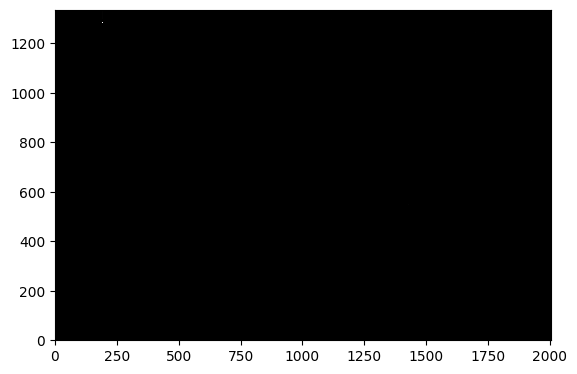

In [4]:
# Create the masterbias
# Loop over all the images in our list and check if they are Bias frames, if they are we append them to the Bias_list
Bias_list = []
count = 0
for im in myimages2:
    if 'bias frame' in im.imagetyp.lower():
        hdulist = fits.open(im.filepath)
        dat = hdulist[0].data
        Bias_list.append(dat)
        hdulist.close

# Then we median combine the images        
Bias_stack = np.stack(Bias_list)
masterbias = np.median(Bias_stack, axis=0)

del Bias_list

# These look pretty good, just weird it doesn't show up on the plot
print(masterbias.min(), masterbias.max(), masterbias.mean())

# Show the resulting masterbias
fig = figure()
frame = fig.add_subplot(1,1,1)
frame.imshow(masterbias, interpolation='none', origin='lower', cmap='gray')
show(fig)
close(fig)

-1.2333333333333334 58.64333333333333 -0.0007344978207258131


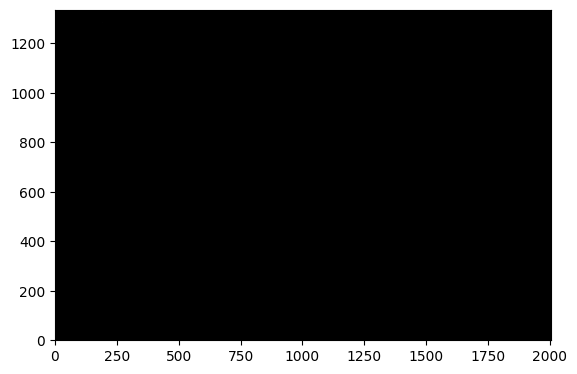

In [5]:
# Create the masterdark
# Loop over all the images in our list and check if they are Dark frames, if they are append them to the list
# We didn't have time to shoot our own darks, so we used older ones

Darks_list = []
count = 0
for im in myimages:
    if 'dark frame' in im.imagetyp.lower():
        hdulist = fits.open(im.filepath)
        dat = hdulist[0].data
        Darks_list.append((dat - masterbias)/im.exptime)
        hdulist.close

# Then we median combine the darks
Darks_stack = np.stack(Darks_list)
masterdark = np.median(Darks_stack, axis=0)

del Darks_list

# The min, max and mean look pretty good, just weird it doesn't show up on the plot
print(masterdark.min(), masterdark.max(), masterdark.mean())

# Show the resulting masterdark
fig = figure()
frame = fig.add_subplot(1,1,1)
norm = ImageNormalize(vmin=5, vmax=100, stretch=SquaredStretch())
frame.imshow(masterdark, interpolation='none', origin='lower', cmap='gray', norm=norm)
show(fig)
close(fig)


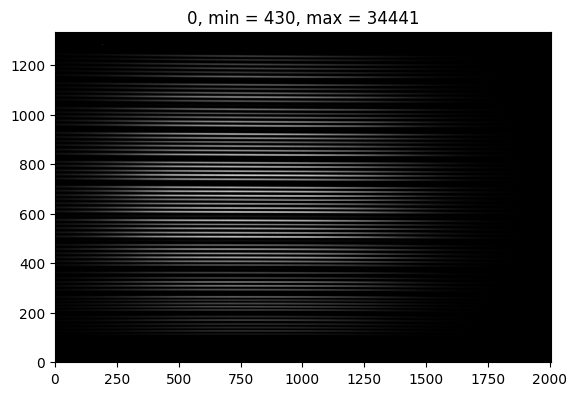

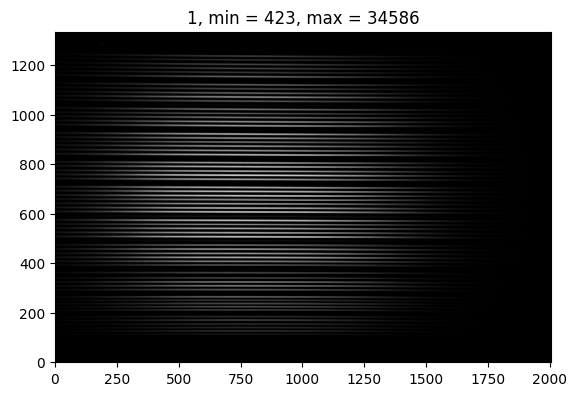

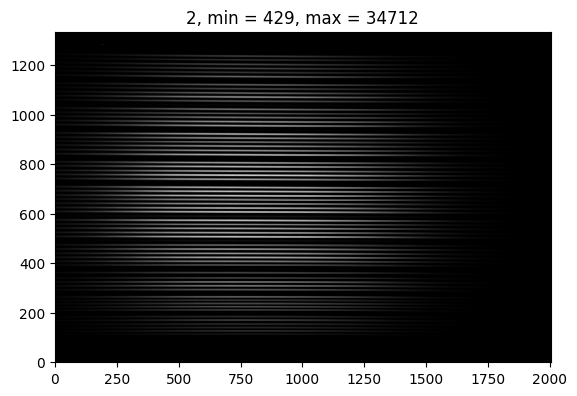

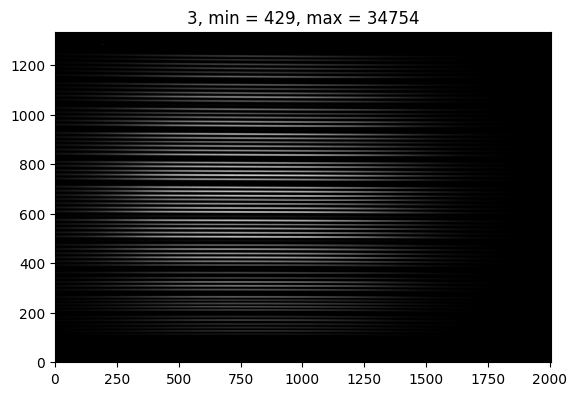

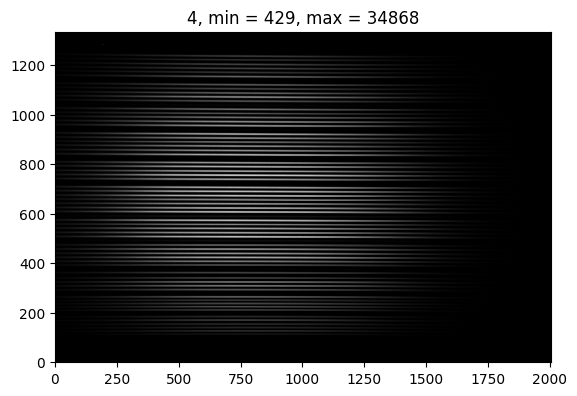

In [6]:
# Let's do the masterflat next

# Loop over all the images in our list and check if they are Bias frames, if they are we append them to the Bias_list
Flats_list = []
count = 0
for im in myimages2:
    if 'flat field' in im.imagetyp.lower():
        hdulist = fits.open(im.filepath)
        dat = hdulist[0].data
        Flats_list.append(dat)
        hdulist.close

# Lets inspect the Flats
c = 0
for obj in Flats_list:
    fig = figure()
    frame = fig.add_subplot(1,1,1)
    norm = ImageNormalize(stretch=SquaredStretch())
    frame.imshow(obj, interpolation='none', origin='lower', cmap='gray', norm=norm)
    frame.set_title(f"{c}, min = {np.min(obj)}, max = {np.max(obj)}")
    show(fig)
    close(fig)
    c += 1

# We see that the first 5 show a proper flat
Flats_list_sorted = Flats_list[0:4]

del Flats_list

-0.2622589531680441 12.556106519742885 2.132789446730223


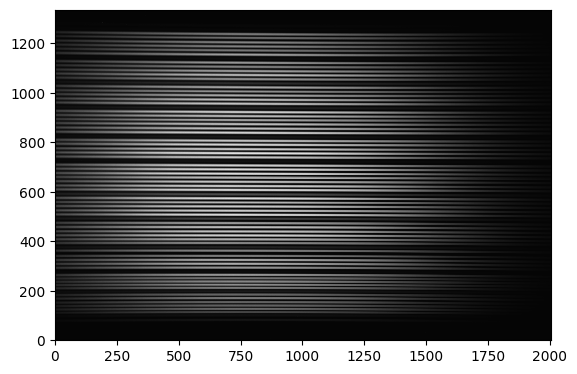

In [7]:
# Then we calibrate the flats with masterbias and median combine the images (We don't need to concern with the darks as the dark current can't really build up during flats
Flats_stack = np.stack(Flats_list_sorted-masterbias)

del Flats_list_sorted

Flats_median = np.median(Flats_stack)
Flats_stack_normalized = Flats_stack/Flats_median
masterflat_to_be_normalized = np.median(Flats_stack_normalized, axis=0)
masterflat = masterflat_to_be_normalized/np.median(masterflat_to_be_normalized)


print(masterflat.min(), masterflat.max(), masterflat.mean())

# Show the resulting masterflat
fig = figure()
frame = fig.add_subplot(1,1,1)
frame.imshow(masterflat, interpolation='none', origin='lower', cmap='gray')
show(fig)
close(fig)

In [8]:
# Now that we have our master calibration files we can work on our lights, first we calibrate
lights = []
for im in myimages2:
    if 'light frame' in im.imagetyp.lower():
        hdulist = fits.open(im.filepath)
        data = hdulist[0].data.astype(float)
        data -= masterdark*im.exptime + masterbias
        # data /= masterflat
        lights.append(data)
        hdulist.close
        
# Let's inspect the lights
# c = 0
# for obj in lights:
#     fig = figure()
#     frame = fig.add_subplot(1,1,1)
#     frame.imshow(obj, interpolation='none', origin='lower', cmap='gray')
#     frame.set_title(f"light {c} with min: {obj.min()}, max: {obj.max()}")
#     show(fig)
#     close(fig)
#     c += 1

-724.6666666666667 46022.1 170.32353165425644


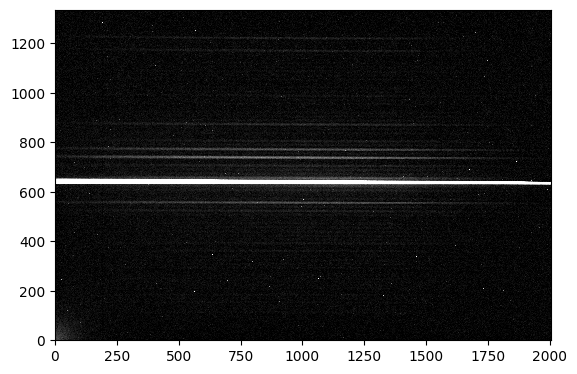

In [85]:
# We use just the first 5, since they appear to be of the same target
# 32-42 excluding 35
lights_sorted_galaxy = lights[32:34]+lights[36:42]
lights_sorted_vega = lights[43:48]
lights_sorted_moon = lights[-5:-1]
lights_calibration = lights[21:25]
lights_sorted_arcturus = lights[29:31]
lights_sorted_regulus = lights[26:27]

lights_stack = np.stack(lights_sorted_arcturus)
masterlight = np.median(lights_stack, axis=0)

vega_stack = np.stack(lights_sorted_vega)
mastervega = np.median(vega_stack, axis=0)

calibration_stack = np.stack(lights_calibration)
mastercalibration = np.median(calibration_stack, axis=0)

# The min, max and mean look pretty good, just weird it doesn't show up on the plot
print(masterlight.min(), masterlight.max(), masterlight.mean())

# Show the resulting masterlight
fig = figure()
frame = fig.add_subplot(1,1,1)
frame.imshow(masterlight, interpolation='none', origin='lower', cmap='gray', vmin=0, vmax=180)
show(fig)
close(fig)

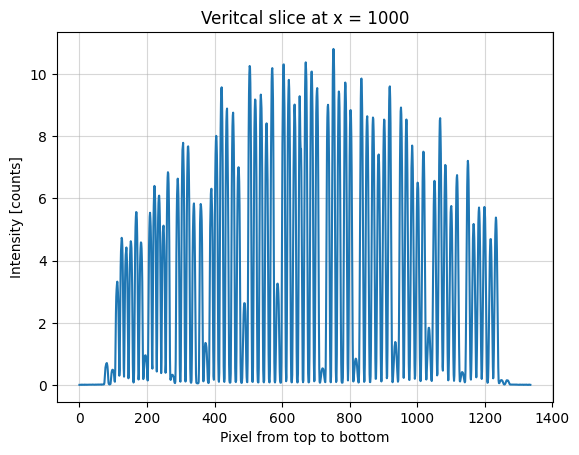

{'fibre_0': [110, 111, 112, 113], 'fibre_1': [122, 123, 124, 125, 126, 127, 128, 129], 'fibre_2': [135, 136, 137, 138, 139, 140, 141, 142], 'fibre_3': [149, 150, 151, 152, 153, 154, 155, 156], 'fibre_4': [164, 165, 166, 167, 168, 169, 170, 171, 172], 'fibre_5': [179, 180, 181, 182, 183, 184, 185, 186], 'fibre_6': [205, 206, 207, 208, 209, 210, 211, 212, 213], 'fibre_7': [218, 219, 220, 221, 222, 223, 224, 225, 226], 'fibre_8': [231, 232, 233, 234, 235, 236, 237, 238, 239, 240], 'fibre_9': [245, 246, 247, 248, 249, 250, 251, 252], 'fibre_10': [258, 259, 260, 261, 262, 263, 264, 265, 266], 'fibre_11': [287, 288, 289, 290, 291, 292, 293, 294, 295], 'fibre_12': [302, 303, 304, 305, 306, 307, 308, 309, 310, 311], 'fibre_13': [317, 318, 319, 320, 321, 322, 323, 324, 325, 326], 'fibre_14': [335, 336, 337, 338, 339, 340, 341, 342], 'fibre_15': [356, 357, 358, 359, 360, 361, 362, 363, 364], 'fibre_16': [386, 387, 388, 389, 390, 391, 392, 393, 394], 'fibre_17': [400, 401, 402, 403, 404, 405, 406

In [10]:
# Now that we have a program which calibrates the images we can start on figuring out where the spectral lines are. This is easiest done by using the flat frames first slice in a vertical line

vert_slice = masterflat[:,1000]

fig = figure()
frame = fig.add_subplot(1,1,1)
frame.plot(vert_slice)
# frame.axis([600, 700, 8, 10])
frame.set_title('Veritcal slice at x = 1000')
frame.set_xlabel('Pixel from top to bottom')
frame.set_ylabel('Intensity [counts]')
frame.grid(alpha = 0.5)
show(fig) 
close(fig)

# Based on the plot we want to exclude values with less then 10000 counts
fibre_locations = np.where(vert_slice>3)[0]

# Now we would like to group all of the values in a single fibre into a single median value to reduce noise, although we do clearly see that the values on the outside are significantly less then the ones in the center.
fibre_locations_dict = {}
i = 1
n = "fibre_0"
c = 0

# Exclude outer 2, because poor signal to noise ratio 
# And add weighting, cause these tops be looking hella mid

for obj in fibre_locations:
    try:
        if obj+1 == fibre_locations[i]:
            try:
                fibre_locations_dict[n].append(obj)
            except:
                fibre_locations_dict[n] = []
                fibre_locations_dict[n].append(obj)
        else:
            fibre_locations_dict[n].append(obj)
            c+=1
            n = f'fibre_{c}'        
        i+=1
    
    except:
        fibre_locations_dict[n].append(obj)
print(fibre_locations_dict)

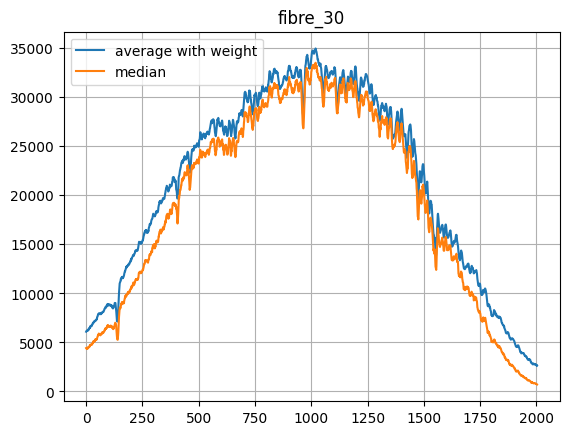

In [86]:
# Now that we have the locations of the fibres we make an intensity plot of the median of all the collumns that a fibre consists of.
def find_maximum_slice(horizontal_slice_dict):
    '''
    :purpose: Finds the location of the slice which contains the maximum value
    :input: Dictionary medians of horizontal slices
    :return: The location of the slice which contains the maximum value
    '''
    Total_max = np.max(horizontal_slice_dict['fibre_0'])
    for i in horizontal_slice_dict:
        Max_of_row = np.max(horizontal_slice_dict[i])
        if Max_of_row>Total_max:
            Total_max = Max_of_row
            location = i
    return location

horizontal_slice_dict = {}
horizontal_slice_moon_dict = {}
horizontal_slice_dict_average = {}
vega_slice_dict_average = {}
calibration_horizontal_dict = {}
flat_horizontal_slice_dict = {}
flat_horizontal_slice_dict_average = {}

# Loop over all the fibres
for i in fibre_locations_dict:
    # Do the slicing
    horizontal_slice = masterlight[fibre_locations_dict[i],:]
    flat_horizontal_slice = masterflat[fibre_locations_dict[i], :]
    calibration_horizontal_slice = mastercalibration[fibre_locations_dict[i], :]
    vega_slice = mastervega[fibre_locations_dict[i], :]
    # Take the median
    horizontal_slices_median = np.median(horizontal_slice, axis=0)
    flat_horizontal_slice_median = np.median(flat_horizontal_slice, axis=0)
    calibration_horizontal_slice_median = np.median(calibration_horizontal_slice, axis=0)
    # Try adding weighting to the different pixels in an attempt to reduce the noise
    horizontal_slices_mean = np.average(horizontal_slice, axis=0, weights = flat_horizontal_slice)
    flat_horizontal_slice_mean = np.average(flat_horizontal_slice, axis=0, weights = flat_horizontal_slice)
    vega_slice_mean = np.average(vega_slice, axis=0, weights = flat_horizontal_slice)
    # Add this median line to the dictionary
    horizontal_slice_dict[i] = horizontal_slices_median
    horizontal_slice_dict_average[i] = horizontal_slices_mean
    calibration_horizontal_dict[i] = calibration_horizontal_slice_median
    flat_horizontal_slice_dict[i] = flat_horizontal_slice_median
    flat_horizontal_slice_dict_average[i] = flat_horizontal_slice_mean
    vega_slice_dict_average[i] = vega_slice_mean
    

# We want to save the horizontal_slice_dict and use it in further stuff
location_of_maximum = find_maximum_slice(horizontal_slice_dict)
# location_of_maximum = ("fibre_40")

# Plot fibre with max intensity
fig = figure()
frame = fig.add_subplot(1,1,1)
frame.plot(horizontal_slice_dict_average[location_of_maximum], label = 'average with weight')
frame.plot(horizontal_slice_dict[location_of_maximum], label = 'median')
frame.set_title(location_of_maximum)
frame.legend()
frame.grid()
show(fig)
close(fig)

# for obj in fibre_locations_dict.keys():
#     fig = figure()
#     frame = fig.add_subplot(1,1,1)
#     frame.plot(horizontal_slice_dict[obj])
#     frame.set_title(obj)
#     frame.grid()
#     show(fig)
#     close(fig)

# horizontal_slice_list_sorted = horizontal_slice_list[27:31:1]
# median_slices = np.median(horizontal_slice_list_sorted, axis=0)

# fig = figure()
# frame = fig.add_subplot(1,1,1)
# frame.plot(median_slices)
# frame.set_title("median of main fibres")
# frame.grid()
# show(fig)
# close(fig)

In [12]:
# Shift calculation based on the biggest spike in the calibration data!

def find_maximum_in_slices(calibration_dict):
    Maximums = {}
    Maximums_list = []
    for i in calibration_dict.keys():
        Maximum = np.where(calibration_dict[i]==np.max(calibration_dict[i]))[0][0]
        Maximums[i] = Maximum
        Maximums_list.append(Maximum)
    centre = np.median(Maximums_list)    
    return(Maximums, centre)

def calculate_shifts(calibration_dict, align_pixel, centre):
    shifts = {}
    for i in calibration_dict.keys():
        shifts[i] = centre - align_pixel[i]
    return shifts

align_pixel, centre = find_maximum_in_slices(calibration_horizontal_dict)
shifts = calculate_shifts(calibration_horizontal_dict, align_pixel, centre)
print(shifts)

{'fibre_0': 7.0, 'fibre_1': 5.0, 'fibre_2': 4.0, 'fibre_3': 5.0, 'fibre_4': 7.0, 'fibre_5': 6.0, 'fibre_6': 4.0, 'fibre_7': 4.0, 'fibre_8': 5.0, 'fibre_9': 4.0, 'fibre_10': 5.0, 'fibre_11': 3.0, 'fibre_12': 2.0, 'fibre_13': 2.0, 'fibre_14': 1.0, 'fibre_15': 3.0, 'fibre_16': 0.0, 'fibre_17': -1.0, 'fibre_18': 0.0, 'fibre_19': 0.0, 'fibre_20': -1.0, 'fibre_21': 0.0, 'fibre_22': 0.0, 'fibre_23': -3.0, 'fibre_24': 0.0, 'fibre_25': 0.0, 'fibre_26': -1.0, 'fibre_27': 1.0, 'fibre_28': -2.0, 'fibre_29': 0.0, 'fibre_30': -3.0, 'fibre_31': -3.0, 'fibre_32': -1.0, 'fibre_33': -4.0, 'fibre_34': -1.0, 'fibre_35': -2.0, 'fibre_36': -1.0, 'fibre_37': -2.0, 'fibre_38': -3.0, 'fibre_39': -2.0, 'fibre_40': -1.0, 'fibre_41': -1.0, 'fibre_42': -1.0, 'fibre_43': -2.0, 'fibre_44': -1.0, 'fibre_45': -1.0, 'fibre_46': -2.0, 'fibre_47': -2.0, 'fibre_48': -2.0, 'fibre_49': -1.0, 'fibre_50': -2.0, 'fibre_51': -1.0, 'fibre_52': -2.0, 'fibre_53': 0.0, 'fibre_54': -1.0, 'fibre_55': 0.0, 'fibre_56': 0.0, 'fibre_57':

In [87]:
def align_spectra(average_dict, shifts):
    aligned_average_dict = {}
    for i in average_dict.keys():
        if shifts[i] > 0:
            shift = int(shifts[i])
            aligned_average_dict[i] = average_dict[i][shift::]
            aligned_average_dict[i] = np.insert(aligned_average_dict[i],0,np.zeros(shift))
        if shifts[i] < 0:
            shift = int(abs(shifts[i]))
            aligned_average_dict[i] = average_dict[i][:-shift:]
            aligned_average_dict[i] = np.insert(aligned_average_dict[i],-1,np.zeros(shift))
        else:
            aligned_average_dict[i] = average_dict[i]
    return aligned_average_dict

def crop_spectra(aligned_average_dict, shifts):
    maximum_shift = 0
    minimum_shift = 0
    cropped = {}
    for i in shifts:
        if shifts[i] > maximum_shift:
            maximum_shift = shifts[i]
        elif shifts[i] < minimum_shift:
            minimum_shift = shifts[i] 
    
    minimum_shift = int(abs(minimum_shift))
    maximum_shift = int(abs(maximum_shift))
    
    for i in aligned_average_dict.keys():
        cropped[i] = aligned_average_dict[i][maximum_shift:-minimum_shift:]
    return cropped, minimum_shift, maximum_shift
    
def get_background(aligned_average_dict):
    aligned_average_list = []
    for i in aligned_average_dict.keys():
        aligned_average_list.append(aligned_average_dict[i])
    aligned_stack = np.stack(aligned_average_list)
    aligned_median = np.median(aligned_stack, axis=0)
    return aligned_median

def background_subtraction(aligned_average_dict,background):
    background_subtracted = {}
    for i in aligned_average_dict.keys():
        background_subtracted[i] = aligned_average_dict[i] / background
    return background_subtracted


aligned_average_dict = align_spectra(horizontal_slice_dict, shifts)
cropped, minimum_shift, maximum_shift = crop_spectra(aligned_average_dict, shifts)
background = get_background(cropped)
background_subtracted = background_subtraction(cropped,background)

aligned_vega = align_spectra(vega_slice_dict_average, shifts)
vega_cropped,_,_ = crop_spectra(aligned_vega, shifts)
# for fibre in background_subtracted.keys():
#     fig = figure()
#     frame = fig.add_subplot(1,1,1)
#     frame.plot(cropped[fibre])
#     # frame.plot(wavelenght_calibrated, aligned_average_dict[fibre]/aligned_average_dict[fibre].max())
#     frame.set_title(f"Background subtracted {fibre}")
#     frame.grid() 
#     show(fig)
#     close(fig)

In [14]:

# import specreduce
# from specreduce.calibration_data import load_onedstds
# 
# 
# 
# fig = figure()
# frame = fig.add_subplot(1,1,1)
# frame.plot(flat_horizontal_slice_dict[location_of_maximum])
# frame.set_title("flat horizontal slice")
# frame.grid()
# show(fig)
# close(fig)
# 
# flat_calibrated = horizontal_slice_dict[location_of_maximum]/(flat_horizontal_slice_dict[location_of_maximum]/np.median(flat_horizontal_slice_dict[location_of_maximum]))
# 
# # Baseline is basically noise reduction for the spectroscope (Not sure if worth)
# baseline = spectrapepper.alsbaseline(flat_calibrated, lam=10)
# smoothest_baseline = flat_calibrated - spectrapepper.alsbaseline(flat_calibrated, lam=100000)
# baseline_subtracted = flat_calibrated - baseline
# continuum_removed = flat_calibrated / baseline_subtracted
# 
# # Same thing but now do it for weighted average
# flat_calibrated_average = horizontal_slice_dict_average[location_of_maximum]/(flat_horizontal_slice_dict_average[location_of_maximum]/np.median(flat_horizontal_slice_dict_average[location_of_maximum]))
# baseline_average = spectrapepper.alsbaseline(flat_calibrated_average, lam=10)
# smoothest_baseline_average = flat_calibrated_average - spectrapepper.alsbaseline(flat_calibrated_average, lam=100000)
# baseline_subtracted_average = flat_calibrated_average - baseline_average
# continuum_removed_average = flat_calibrated_average / baseline_subtracted_average
# 
# fig = figure()
# frame = fig.add_subplot(1,1,1)
# frame.plot(baseline)
# frame.set_title("alsbaseline")
# frame.grid()
# show(fig)
# close(fig)
# 
# fig = figure()
# frame = fig.add_subplot(1,1,1)
# frame.plot(flat_calibrated)
# frame.set_title("alsbaseline")
# frame.grid()
# show(fig)
# close(fig)
# 
# fig = figure()
# frame = fig.add_subplot(1,1,1)
# frame.plot(baseline_subtracted)
# frame.set_title("alsbaseline")
# frame.grid()
# show(fig)
# close(fig)
# 
# # flat_calibrated = horizontal_slice_dict['fibre_27']/(horizontal_slice_moon_dict['fibre_27']/np.median(horizontal_slice_moon_dict['fibre_27']))
# 
# flat_calibrated = flat_calibrated[-1::-1]   # Flip
# 
# fig = figure()
# frame = fig.add_subplot(1,1,1)
# frame.plot(flat_calibrated)
# frame.set_title(f"{location_of_maximum} flat calibrated")
# frame.grid()
# show(fig)
# close(fig)


In [15]:
# fig = figure()
# frame = fig.add_subplot(1,1,1)
# frame.plot(flat_calibrated[::-1], label = 'median')
# frame.plot(flat_calibrated_average, label = 'average')
# frame.set_title(f"{location_of_maximum} flat calibrated")
# frame.grid()
# frame.legend()
# show(fig)
# close(fig)
# 
# fig = figure()
# frame = fig.add_subplot(1,1,1)
# frame.plot(baseline_subtracted, label = 'median')
# frame.plot(baseline_subtracted_average, label = 'average')
# frame.set_title(f"{location_of_maximum} baseline_subtracted")
# frame.grid()
# frame.legend()
# show(fig)
# close(fig)
# 
# fig = figure()
# frame = fig.add_subplot(1,1,1)
# frame.plot(baseline, label = 'median')
# frame.plot(baseline_average, label = 'average')
# frame.set_title(f"{location_of_maximum} baseline")
# frame.grid()
# frame.legend()
# show(fig)
# close(fig)

In [16]:
# from matplotlib.pyplot import subplots
# 
# # baseline_subtracted, smoothest_baseline = -baseline_subtracted, -smoothest_baseline
# 
# fig, ax = subplots()
# ax.plot(flat_calibrated[::-1]/flat_calibrated.max(), label="raw")
# ax.plot(smoothest_baseline/smoothest_baseline.max(), label="smooth")
# ax.plot(baseline_subtracted/baseline_subtracted.max(), label="baseline")
# fig.legend()
# show()
# close(fig)
# 
# 
# dat2 = baseline_subtracted
# data_var = baseline_subtracted - smoothest_baseline
# 
# fig, ax = subplots()
# ax.plot(data_var)
# show()
# close(fig)
# 
# deriv = []
# der2 = []
# for i in range(data_var.size-1):
#     d = data_var[i+1]-data_var[i]
#     d2 = dat2[i+1]-dat2[i]
#     deriv.append(d)
#     der2.append(d2)
# deriv = np.array(deriv)/np.max(deriv)
# der2 = np.array(der2)/np.max(der2)
# fig, ax = subplots(1, 1)
# ax.plot(((deriv)), label="baseline")
# ax.plot(der2, label="baseline - smooth")
# ax.grid()
# ax.legend(loc='best')
# show()
# close(fig)
# 
# data_var = deriv
# deriv = []
# 
# for i in range(data_var.size-1):
#     d = data_var[i+1]-data_var[i]
#     deriv.append(d)
# deriv = np.array(deriv)/np.max(deriv)
# fig, ax = subplots()
# fin = 10**((deriv))
# ax.plot(fin/fin.max())
# fin_base = baseline_subtracted - smoothest_baseline 
# ax.plot(fin_base/fin_base.max())
# ax.grid()
# fig.set_tight_layout(True)
# show()
# close(fig)
# 
# 
# fig, ax = subplots()
# ax.plot(fin/fin.max(), label="peaks", alpha=0.5)
# ax.plot(baseline_subtracted/baseline_subtracted.max(), label="baseline")
# ax.grid()
# show()
# close(fig)
# # Timo code

In [17]:
# from matplotlib.pyplot import subplots
# 
# # baseline_subtracted, smoothest_baseline = -baseline_subtracted, -smoothest_baseline
# 
# fig, ax = subplots()
# ax.plot(flat_calibrated_average/flat_calibrated_average.max(), label="raw")
# ax.plot(smoothest_baseline_average/smoothest_baseline_average.max(), label="smooth")
# ax.plot(baseline_subtracted_average/baseline_subtracted_average.max(), label="baseline")
# fig.legend()
# show()
# close(fig)
# 
# 
# dat2_average = baseline_subtracted_average
# data_var_average = baseline_subtracted_average - smoothest_baseline_average
# 
# fig, ax = subplots()
# ax.plot(data_var_average)
# show()
# close(fig)
# 
# deriv_average = []
# der2_average = []
# for i in range(data_var_average.size-1):
#     d_average = data_var_average[i+1]-data_var_average[i]
#     d2_average = dat2_average[i+1]-dat2_average[i]
#     deriv_average.append(d_average)
#     der2_average.append(d2_average)
# deriv_average = np.array(deriv_average)/np.max(deriv_average)
# der2_average = np.array(der2_average)/np.max(der2_average)
# fig, ax = subplots(1, 1)
# ax.plot(((deriv_average)), label="baseline")
# ax.plot(der2_average, label="baseline - smooth")
# ax.grid()
# ax.legend(loc='best')
# show()
# close(fig)
# 
# data_var_average = deriv_average
# deriv_average = []
# 
# for i in range(data_var_average.size-1):
#     d_average = data_var_average[i+1]-data_var_average[i]
#     deriv_average.append(d_average)
# deriv_average = np.array(deriv_average)/np.max(deriv_average)
# 
# fig, ax = subplots()
# fin_average = 10**((deriv_average))
# ax.plot(fin_average/fin_average.max())
# fin_base_average = baseline_subtracted_average - smoothest_baseline_average
# ax.plot(fin_base_average/fin_base_average.max())
# ax.grid()
# fig.set_tight_layout(True)
# show()
# close(fig)
# 
# 
# fig, ax = subplots()
# ax.plot(fin_average/fin_average.max(), label="peaks", alpha=0.5)
# ax.plot(baseline_subtracted_average/baseline_subtracted_average.max(), label="baseline")
# ax.plot(flat_calibrated_average/flat_calibrated_average.max(), label="raw")
# ax.grid()
# show()
# close(fig)
# # Timo code 2

In [18]:
# # %matplotlib
# fig, ax = subplots()
# ax.plot(fin/fin.max(), label="peaks", alpha=0.5)
# ax.plot(fin_average/fin_average.max(), label="average peaks", alpha = 0.5)
# ax.plot(flat_calibrated_average/flat_calibrated_average.max(), label="raw average", alpha = 0.5)
# ax.plot(flat_calibrated[::-1]/flat_calibrated.max(), label="raw median", alpha = 0.5)
# ax.legend()
# ax.grid()
# show(block=True)
# close(fig)

In [19]:
# from specreduce.calibration_data import load_pypeit_calibration_lines, load_onedstds, load_MAST_calspec
# 
# 
# # print(specreduce.calibration_data.PYPEIT_CALIBRATION_LINELISTS)
# 
# ZnI = load_pypeit_calibration_lines('ZnI')
# HgI = load_pypeit_calibration_lines('HgI')
# CdI = load_pypeit_calibration_lines('CdI')
# 
# wavelengthZnI = []
# amplitudeZnI = []
# for i in range(len(ZnI)):
#     row=ZnI[i]
#     wave = row['wave']
#     wavelengthZnI.append(wave.value)
#     amplitude = row['amplitude']
#     amplitudeZnI.append(amplitude)
# 
# wavelengthHgI = []
# amplitudeHgI = []
# for i in range(len(HgI)):
#     row=HgI[i]
#     wave = row['wave']
#     wavelengthHgI.append(wave.value)
#     amplitude = row['amplitude']
#     amplitudeHgI.append(amplitude)
# 
# wavelengthCdI = []
# amplitudeCdI = []
# for i in range(len(CdI)):
#     row=CdI[i]
#     wave = row['wave']
#     wavelengthCdI.append(wave.value)
#     amplitude = row['amplitude']
#     amplitudeCdI.append(amplitude)
# 
# # np.array(amplitudeZnI)
# # np.array(amplitudeHgI)
# # np.array(amplitudeCdI)
# # np.array(amplitudeZnI)
# # np.array(amplitudeHgI)
# # np.array(amplitudeCdI)
# # 
# # combine_amplitude = amplitudeZnI+amplitudeHgI+amplitudeCdI
# # combine_wavelenght = wavelengthZnI+wavelengthHgI+wavelengthCdI
# 
# 
# 
# 
# fig = figure()
# frame = fig.add_subplot(1,1,1)
# frame.plot(wavelengthZnI, amplitudeZnI)
# frame.plot(wavelengthHgI, amplitudeHgI)
# frame.plot(wavelengthCdI, amplitudeCdI)
# frame.set_title("Spectral lines")
# frame.set_xlabel(f"Wavelength")
# frame.set_ylabel(f"Flux")
# frame.grid()
# show(fig)
# close(fig)
# 
# 
# # WARNING: Downloading of https://raw.githubusercontent.com/astropy/specreduce-data/main/specreduce_data/reference_data/onedstds\gemini\BD+28 4211 failed: URL can't contain control characters. '/astropy/specreduce-data/main/specreduce_data/reference_data/onedstds\\gemini\\BD+28 4211' (found at least ' ') [specreduce.calibration_data]
# # WARNING: Can't load BD+28 4211 from gemini. [specreduce.calibration_data]
# Specreduce

In [20]:
# fig = figure()
# frame = fig.add_subplot(1,1,1)
# for fibre in calibration_horizontal_dict.keys():
#     frame.plot(calibration_horizontal_dict[fibre], label = fibre)
# frame.set_title(f"Calibration data")
# frame.grid()
# show(fig)
# close(fig)

[ 507  571  573 1046 1064 1313 1316 1618 1621 1846 1853 1917 1952]


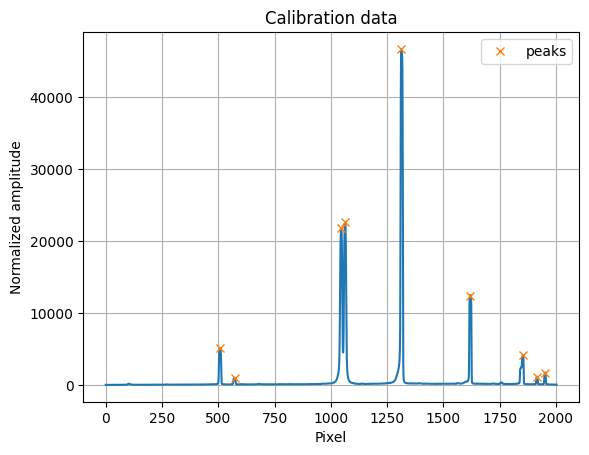

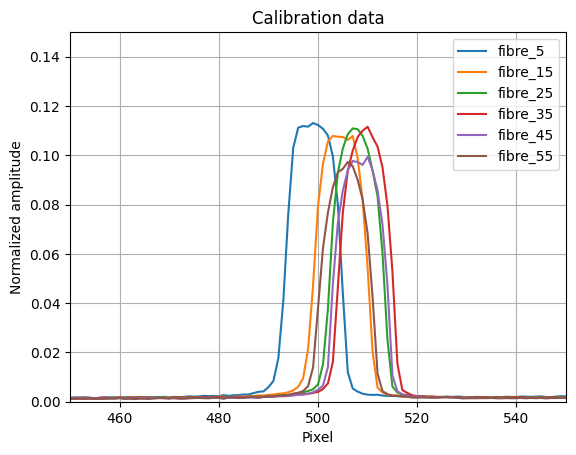

In [21]:
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Take a spectrum with 0 shift
fibre = 'fibre_29'
Y = calibration_horizontal_dict[fibre]



# find_peaks gets the maxima, so we multiply our signal by -1
# Y *= -1
# get the actual peaks
peaks, _ = find_peaks(Y, height=500)
# multiply back for plotting purposes

a1 = peaks[np.array([0,2,3,4,5,7,10,11,12])]

print(peaks)

fig = figure()
frame = fig.add_subplot(1,1,1)
frame.plot(Y)
frame.plot(a1, Y[a1], label = 'peaks', marker = 'x', linewidth = 0)
frame.set_title(f"Calibration data")
frame.set_ylabel('Normalized amplitude')
frame.set_xlabel('Pixel')
frame.grid()
frame.legend()
show(fig)
close(fig)

fibres = ['fibre_5', 'fibre_15', 'fibre_25', 'fibre_35', 'fibre_45', 'fibre_55']

fig = figure()
frame = fig.add_subplot(1,1,1)
for fibre in fibres:
    frame.plot(calibration_horizontal_dict[fibre]/np.max(calibration_horizontal_dict[fibre]), label = fibre)
frame.axis([450, 550, 0, 0.15])
frame.set_title(f"Calibration data")
frame.set_ylabel('Normalized amplitude')
frame.set_xlabel('Pixel')
frame.grid()
frame.legend()
show(fig)
close(fig)

[ 507 1046 1064 1313 1618]
 
-1.217 x + 7060


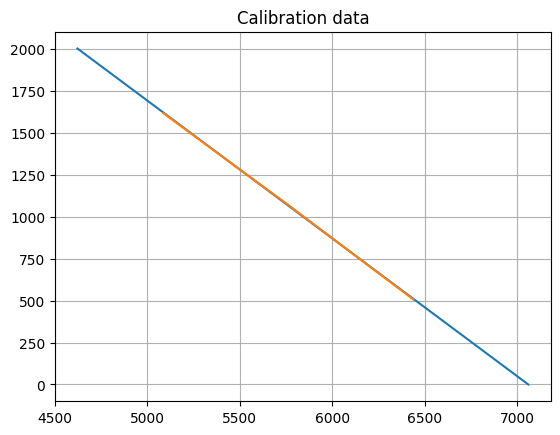

In [160]:
pixels_xaxis = 2004

# # Vega
# a1 = np.array([199,1597,1863])
# # Hb = 486.1, Ha = 656.3, O2 = 686.9
# c1 = np.array([486.1,656.3,686.9])
a2 = np.arange(0,pixels_xaxis, 1)
a1 = peaks[np.array([0,3,4,5,7])]
c1 = np.array([6438, 5791, 5770, 5461, 5086])
print(a1)

def wavelenghtfit(a1,c1, degree):
    ''''
    Function to calculate the wavelenght calibration polynomial
    input: a1 and c1 are arrays where the first is the pixel values found and c1 are the wavelength values
    output: wavelenght calibration polynomial
    '''
    y = np.poly1d(np.polyfit(a1,c1,degree)) # Need to add error
    return(y)

y = (wavelenghtfit(a1,c1, 1))
print(y)

wavelenght_calibrated = np.polyval(y, a2)

cropped_wavelenght = wavelenght_calibrated[maximum_shift:-minimum_shift:]

fig = figure()
frame = fig.add_subplot(1,1,1)
frame.plot(wavelenght_calibrated, a2, label = fibre)
frame.plot(c1,a1)
frame.set_title(f"Calibration data")
frame.grid()
show(fig)
close(fig)

In [201]:
# Peaks
def peaks_to_wavelenght(Array_with_y, flip=False, crop=False):
    peaks_pixel = []
    x_lenght = wavelenght_calibrated.shape[0]
    shifting = 0
    if crop == True:
        if flip == True:
            for x,_ in Array_with_y:
                peaks_pixel.append(int(x_lenght-x)-minimum_shift+shifting)
        else:
            for x,_ in Array_with_y:
                peaks_pixel.append(int(x)-maximum_shift+shifting)
    else:
        for x,_ in Array_with_y:
            peaks_pixel.append(int(x+shifting))
    return peaks_pixel, np.polyval(y,peaks_pixel)



Arcturus_peaks_with_y = np.array([(965, 1.0), (1474, 0.5678502003175749), (139, 0.5352656122914062), (406, 0.40614839618638304), (1053, 0.36309291176020014), (1553, 0.26215663963439767), (461, 0.25314745142294764), (1425, 0.1614577180171796), (1116, 0.13126752987567908), (1213, 0.07589275430707912), (1363, 0.06232677402455454), (740, 0.05271710474836562)])
Vega_peaks_with_y = np.array([(198, 1.0), (1597, 0.0010763035604415474), (1863, 0.0007290668308719731)])
Regulus_peaks_with_y = np.array([(1797, 1.0), (398, 0.09840773414254268), (132, 0.015318963453609722)])
Moon_peaks_with_y = np.array([(396, 1.0), (954, 0.638321253457336), (128, 0.5756135064098958), (1546, 0.2567646603530915), (1464, 0.11084853834134842)])

Arcturus_peaks_pixel, Arcturus_peaks = peaks_to_wavelenght(Arcturus_peaks_with_y, False, True)
Vega_peaks_pixel, Vega_peaks = peaks_to_wavelenght(Vega_peaks_with_y, True, True)
Regulus_peaks_pixel, Regulus_peaks = peaks_to_wavelenght(Regulus_peaks_with_y)
Moon_peaks_pixel, Moon_peaks = peaks_to_wavelenght(Moon_peaks_with_y)


print(f"Arcturus: ", Arcturus_peaks, Arcturus_peaks_pixel)
print(f"Vega: ", Vega_peaks, Vega_peaks_pixel)
print(f"Regulus: ", Regulus_peaks, Regulus_peaks_pixel)
print(f"Moon: ", Moon_peaks, Moon_peaks_pixel)

Arcturus:  [5893.73847649 5274.14688985 6899.20537348 6574.19367676 5786.61851652
 5177.98238033 6507.24370177 5333.7932312  5709.93036336 5591.85495294
 5409.26411208 6167.62473778] [958, 1467, 132, 399, 1046, 1546, 454, 1418, 1109, 1206, 1356, 733]
Vega:  [4866.3606786  6569.32458767 6893.11901212] [1802, 403, 137]
Regulus:  [4872.44703996 6575.41094903 6899.20537348] [1797, 398, 132]
Moon:  [6577.84549357 5898.60756558 6904.07446257 5177.98238033 5277.79870667] [396, 954, 128, 1546, 1464]


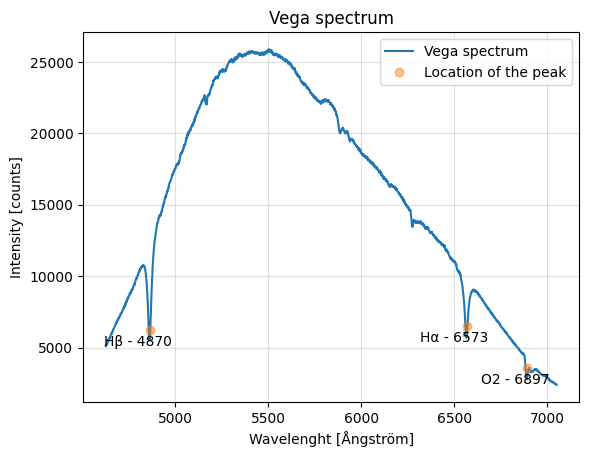

In [202]:
n_vega = ['Hβ - 4870', 'Hα - 6573', 'O2 - 6897']

fig = figure()
frame = fig.add_subplot(1,1,1)
frame.plot(cropped_wavelenght, vega_cropped[location_of_maximum], label = 'Vega spectrum')
frame.plot(Vega_peaks,vega_cropped[location_of_maximum][Vega_peaks_pixel], marker = 'o', alpha = 0.5, linewidth = 0, label = 'Location of the peak')
for i, txt in enumerate(n_vega):
    frame.annotate(txt, (Vega_peaks[i], vega_cropped[location_of_maximum][Vega_peaks_pixel][i]), (Vega_peaks[i]-250, vega_cropped[location_of_maximum][Vega_peaks_pixel][i]-1100))
frame.set_title(f"Vega spectrum")
frame.set_ylabel('Intensity [counts]')
frame.set_xlabel('Wavelenght [Ångström]')
frame.legend()
frame.grid(alpha = 0.4)
fig.savefig('Vega.png', dpi=300)
show(fig)
close(fig)

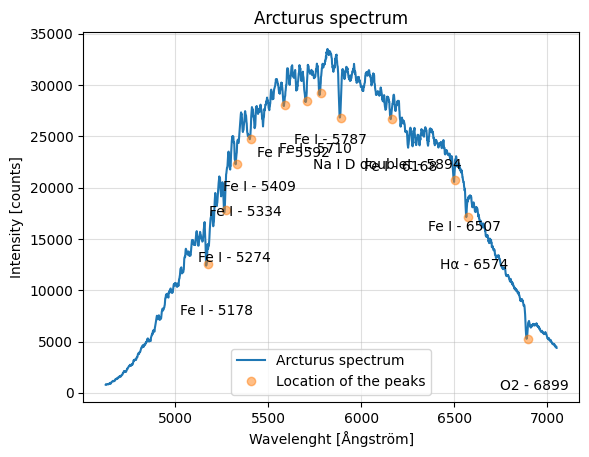

In [203]:
# n_arcturus = ['5894', '5274', '6899', '6574', '5787', '5178', '6507', '5334', '5710', '5592', '5409', '6168']
n_arcturus = ['Na I D doublet - 5894', 'Fe I - 5274', 'O2 - 6899', 'Hα - 6574', 'Fe I - 5787', 'Fe I - 5178', 'Fe I - 6507', 'Fe I - 5334', 'Fe I - 5710', 'Fe I - 5592', 'Fe I - 5409', 'Fe I - 6168']
Arcturus = np.loadtxt('Arcturus.txt')

fig = figure()
frame = fig.add_subplot(1,1,1)
frame.plot(cropped_wavelenght, Arcturus, label = 'Arcturus spectrum')
frame.plot(Arcturus_peaks,Arcturus[Arcturus_peaks_pixel], marker = 'o', alpha = 0.5, linewidth = 0, label = 'Location of the peaks')
for i, txt in enumerate(n_arcturus):
    frame.annotate(txt, (Arcturus_peaks[i], Arcturus[Arcturus_peaks_pixel][i]), (Arcturus_peaks[i]-150, Arcturus[Arcturus_peaks_pixel][i]-5000))
frame.set_title(f"Arcturus spectrum")
frame.set_ylabel('Intensity [counts]')
frame.set_xlabel('Wavelenght [Ångström]')
frame.legend(loc = 'lower center')
frame.grid(alpha = 0.4)
fig.savefig('Arcturus.png', dpi=300)
show(fig)
close(fig)

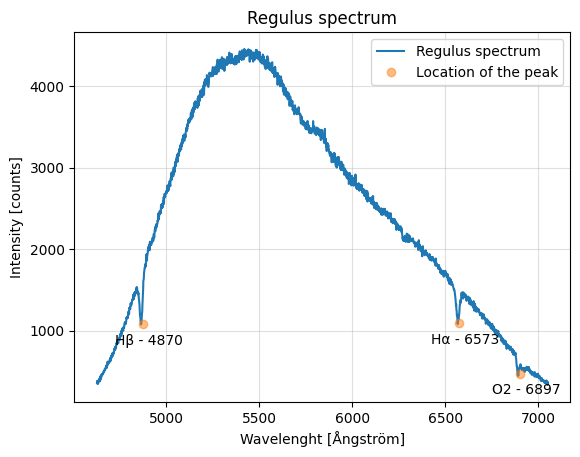

In [204]:
n_Regulus = ['Hβ - 4870', 'Hα - 6573', 'O2 - 6897']
Regulus = np.loadtxt('Regulus.txt')

fig = figure()
frame = fig.add_subplot(1,1,1)
frame.plot(cropped_wavelenght, Regulus, label = 'Regulus spectrum')
frame.plot(Regulus_peaks,Regulus[Regulus_peaks_pixel], marker = 'o', alpha = 0.5, linewidth = 0, label = 'Location of the peak')
for i, txt in enumerate(n_Regulus):
    frame.annotate(txt, (Regulus_peaks[i], Regulus[Moon_peaks_pixel][i]), (Regulus_peaks[i]-150, Regulus[Regulus_peaks_pixel][i]-250))
frame.set_title(f"Regulus spectrum")
frame.set_ylabel('Intensity [counts]')
frame.set_xlabel('Wavelenght [Ångström]')
frame.legend()
frame.grid(alpha = 0.4)
fig.savefig('Regulus.png', dpi=300)
show(fig)
close(fig)

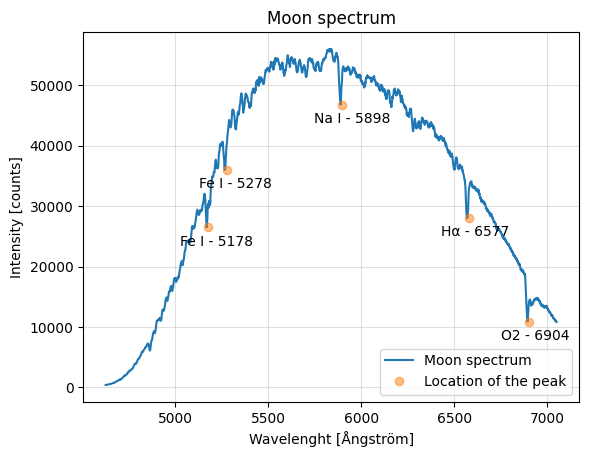

In [205]:
n_Moon = ['Hα - 6577', 'Na I - 5898', 'O2 - 6904', 'Fe I - 5178', 'Fe I - 5278']
Moon = np.loadtxt('Moon.txt')

fig = figure()
frame = fig.add_subplot(1,1,1)
frame.plot(cropped_wavelenght, Moon, label = 'Moon spectrum')
frame.plot(Moon_peaks,Moon[Moon_peaks_pixel], marker = 'o', alpha = 0.5, linewidth = 0, label = 'Location of the peak')
for i, txt in enumerate(n_Moon):
    frame.annotate(txt, (Moon_peaks[i], Moon[Moon_peaks_pixel][i]), (Moon_peaks[i]-150, Moon[Moon_peaks_pixel][i]-3000))
frame.set_title(f"Moon spectrum")
frame.set_ylabel('Intensity [counts]')
frame.set_xlabel('Wavelenght [Ångström]')
frame.legend()
frame.grid(alpha = 0.4)
fig.savefig('Moon.png', dpi=300)
show(fig)
close(fig)

We find emmision lines: []
We find absorption lines: [4671.59711502 4674.03165957 4678.90074866 4681.3352932  4684.98711002
 4692.29074365 4703.2461941  4709.33255546 4712.98437228 4715.41891683
 4719.07073364 4721.50527819 4725.15709501 4727.59163955 4732.46072864
 4734.89527318 4738.54709    4742.19890682 4750.71981273 4754.37162954
 4758.02344636 4760.4579909  4762.89253545 4765.32707999 4770.19616908
 4773.8479859  4776.28253045 4778.71707499 4796.97615908 4811.58342634
 4818.88705998 4822.5388768  4827.40796589 4831.0597827  4837.14614406
 4840.79796088 4843.23250543 4845.66704997 4851.75341133 4854.18795588
 4859.05704497 4861.49158951 4863.92613406 4867.57795087 4871.22976769
 4873.66431224 4877.31612905 4880.96794587 4884.61976269 4887.05430723
 4889.48885178 4894.35794087 4896.79248541 4905.31339132 4907.74793586
 4915.0515695  4919.92065859 4924.78974768 4927.22429222 4934.52792586
 4943.04883176 4946.70064858 4949.13519312 4955.22155449 4961.30791585
 4966.17700494 4969.8288

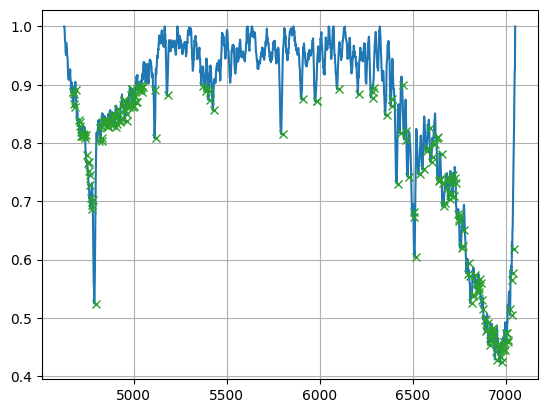

In [184]:
# Use the peak finder on certain spectra
def continuum_removal(points):
    x, y = points.T
    augmented = np.concatenate([points, [(x[0], np.min(y)-1), (x[-1], np.min(y)-1)]], axis=0)
    hull = ConvexHull(augmented)
    continuum_points = points[np.sort([v for v in hull.vertices if v < len(points)])]
    continuum_function = interp1d(*continuum_points.T)
    yprime = y / continuum_function(x)

    return yprime

fibre = location_of_maximum

points = np.c_[cropped_wavelenght, cropped[fibre]]
hull_subtracted = continuum_removal(points)


# processed_signal = (background_subtracted[fibre])


emmision, _ = find_peaks(hull_subtracted[::-1], height=1.093)
absorption, _ = find_peaks(hull_subtracted[::-1]*-1, height=-0.9)

emmision_calibrated = np.polyval(y, emmision)
absorption_calibrated = np.polyval(y, absorption)
print(f"We find emmision lines: {emmision_calibrated[::-1]}")
print(f"We find absorption lines:", absorption_calibrated[::-1])

# plt.plot(wavelenght_calibrated, ss.wiener(background_subtracted[fibre], 80), label = "wiener")
plt.plot(cropped_wavelenght, hull_subtracted[::-1])
# plt.plot(wavelenght_calibrated, aligned_average_dict[fibre][::-1])
# plt.plot(wavelenght_calibrated[::-1], convexhull)
# plt.plot(wavelenght_calibrated, spectrapepper.alsbaseline(aligned_average_dict[location_of_maximum], lam=1, remove=True))
plt.plot(emmision_calibrated, hull_subtracted[::-1][emmision], "x")
plt.plot(absorption_calibrated, hull_subtracted[::-1][absorption], "x")
plt.grid()
plt.show()


In [26]:
# Let's look for some lines
# 
# for fibre in background_subtracted.keys():
#     fig = figure()
#     frame = fig.add_subplot(1,1,1)
#     frame.plot(cropped_wavelenght, cropped[fibre])
#     frame.set_title(f"background_subtracted {fibre}")
#     frame.grid()
#     show(fig)
#     close(fig)

In [27]:
# continuum_subtracted = spectrapepper.alsbaseline(horizontal_slice_dict_average[location_of_maximum], lam=10, remove=True)
# # Do the same for the moon to look what is sky
# # continuum_subtracted_moon = spectrapepper.alsbaseline(horizontal_slice_dict_average[location_of_maximum], lam=10, remove=True)
# 
# fig = figure()
# frame = fig.add_subplot(1,1,1)
# # frame.plot(horizontal_slice_dict_average[location_of_maximum], label = 'average')
# frame.plot(wavelenght_calibrated, continuum_subtracted[::-1]/continuum_subtracted.max(), label = 'baseline_subtracted')
# # frame.plot(wavelenght_calibrated, continuum_subtracted_moon[::-1]/continuum_subtracted_moon.max(), label = 'moon')
# 
# frame.set_title(f"{location_of_maximum} baseline")
# frame.grid()
# frame.legend()
# show(fig)
# close(fig)

{'fibre_0': array([ 9.13416429, 11.95243491, 12.33740753, ...,  9.40855263,
        7.28319444,  9.13257576]), 'fibre_1': array([12.49859622, 12.5719528 ,  9.98013609, ...,  7.41224189,
       11.14972222,  7.85998818]), 'fibre_2': array([ 9.78556525, 12.85977222,  8.73203599, ...,  8.84933862,
        9.15521223,  8.25555556]), 'fibre_3': array([ 9.73771191,  7.26587437,  9.89253781, ..., 10.97979976,
        6.6810842 , 12.17894376]), 'fibre_4': array([7.48185069, 5.51865079, 6.62915246, ..., 9.09043056, 9.30341403,
       8.9854927 ]), 'fibre_5': array([5.01807511, 6.12619786, 5.78518384, ..., 9.05582375, 9.09734388,
       6.69137701]), 'fibre_6': array([ 6.67066418,  5.72409485,  5.1427201 , ...,  3.43540648,
       10.84779896, 11.90681291]), 'fibre_7': array([7.53945405, 5.31511319, 5.54673672, ..., 6.91457143, 9.42133761,
       6.39552752]), 'fibre_8': array([6.08704358, 6.55187475, 7.19202937, ..., 7.46425798, 8.70838878,
       9.55060873]), 'fibre_9': array([ 4.36068035,  4

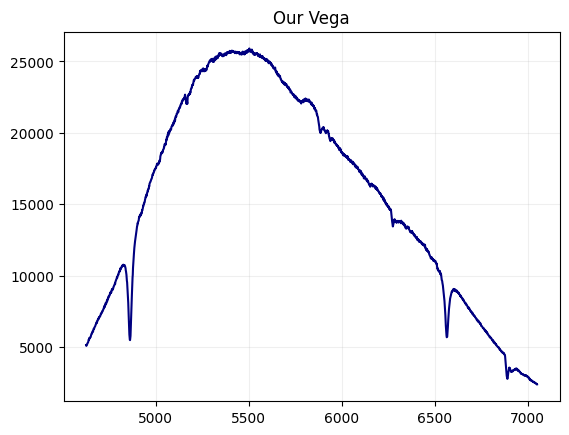

In [28]:
# hdulist = fits.open('miles spectra/arcturus_miles.fits')
# hdr = hdulist[0].header
# dat = hdulist[0].data
# vega_miles = dat[0,:]
# print(vega_miles)

# getting some basic information on the miles spectrum

# hdulist = fits.open('miles_spec_fits_s0592.fits')
# 
# hdr = hdulist[0].header
# dat = hdulist[0].data
# vega_miles = dat[0,:]

vega_calibration = np.loadtxt('miles_spec_txt_s0592.txt')

wavelenght = []
values = []

size = int(vega_calibration.size/2)

for i in range(size):
    wavelenght.append(vega_calibration[i][0])
    values.append(vega_calibration[i][1])

# convert both to np arrays
vega_calibration_wavelenght = np.array(wavelenght)
vega_calibration_values = np.array(values)


# fig=figure()
# frame=fig.add_subplot(1,1,1)
# frame.plot(vega_calibration_wavelenght, vega_calibration_values,color="navy", label="Vega spectrum")
# frame.set_title("Vega-like star spectrum from MILES")
# frame.grid(alpha=0.2)
# show()
# close(fig)
print(vega_cropped)

fig=figure()
frame=fig.add_subplot(1,1,1)
frame.plot(cropped_wavelenght, vega_cropped[location_of_maximum],color="navy", label="Vega spectrum")
frame.set_title("Our Vega")
frame.grid(alpha=0.2)
show()
close(fig)

In [29]:
# convert both to np arrays
vega_calibration_wavelenght = np.array(wavelenght)
vega_calibration_values = np.array(values)


# First we get the max and min values of our actual data
minimum_wavelenght = cropped_wavelenght[0]
maximum_wavelenght = cropped_wavelenght[-1]

# We crop the calibration data to our range
mask1 = vega_calibration_wavelenght > minimum_wavelenght
vega_calibration_wavelenght = vega_calibration_wavelenght[mask1]
vega_calibration_values = vega_calibration_values[mask1]

mask2 = vega_calibration_wavelenght < maximum_wavelenght
vega_calibration_wavelenght = vega_calibration_wavelenght[mask2]
vega_calibration_values = vega_calibration_values[mask2]

# Then we interpolate the calibration data so it matches ours
# la = len(aligned_average_dict[location_of_maximum])


wavelenght_calibrated = wavelenght_calibrated[::-1]
interpolated_vega_calibration_values = np.interp(wavelenght_calibrated, vega_calibration_wavelenght, vega_calibration_values)

# Let's smooth both curves so we can find an accurate response curve
smooth_data = vega_slice_dict_average[location_of_maximum] - spectrapepper.alsbaseline(vega_slice_dict_average[location_of_maximum], lam=1000)
# smooth_calibrated = interpolated_vega_calibration_values - spectrapepper.alsbaseline(interpolated_vega_calibration_values, lam=100000)
# 
# fig = figure()
# frame = fig.add_subplot(1,1,1)
# frame.plot(wavelenght_calibrated, smooth_data)
# frame.plot(wavelenght_calibrated, smooth_calibrated)
# frame.set_title(f"{location_of_maximum} responsecurve")
# frame.grid()
# show(fig)
# close(fig)



# Now we can calculate the response curve and calibrate our data
# Currently doesn't take into account the peaks
response = vega_slice_dict_average[location_of_maximum] / interpolated_vega_calibration_values
correction = 1/response
smooth_correction = correction - spectrapepper.alsbaseline(correction, lam=10)
response_calibrated = vega_slice_dict_average[location_of_maximum]*correction



fig = figure()
frame = fig.add_subplot(1,1,1)
frame.plot(wavelenght_calibrated, smooth_data)
frame.set_title(f"{location_of_maximum} responsecurve")
frame.grid()
show(fig)
close(fig)

fig = figure()
frame = fig.add_subplot(1,1,1)
frame.plot(wavelenght_calibrated, vega_slice_dict_average[location_of_maximum])
frame.set_title(f"{location_of_maximum} before response_calibrated")
frame.grid()
show(fig)
close(fig)

fig = figure()
frame = fig.add_subplot(1,1,1)
frame.plot(wavelenght_calibrated, response_calibrated)
frame.set_title(f"{location_of_maximum} response_calibrated")
frame.grid()
show(fig)
close(fig)

fig = figure()
frame = fig.add_subplot(1,1,1)
frame.plot(wavelenght_calibrated, interpolated_vega_calibration_values)
frame.set_title(f"{location_of_maximum} Calibration data")
frame.grid()
show(fig)
close(fig)

ValueError: array of sample points is empty

In [ ]:
from scipy.optimize import curve_fit
def f(x,n,b,p):
    '''
    Returns the value of a Gaussian function with amplitude amp centered at position mu with width sigma and 
    offset with respect to the x axis of zero
    '''
    return b+n/(x**p)

m1 = (interpolated_vega_calibration_values[300]+interpolated_vega_calibration_values[500])/2
m2 = (interpolated_vega_calibration_values[1700]+interpolated_vega_calibration_values[1900])/2

no_peak_part1 = list(interpolated_vega_calibration_values[0:300])
no_peak_part2 = list(m1*np.ones(200))
no_peak_part3 = list(interpolated_vega_calibration_values[500:1700])
no_peak_part4 = list(m2*np.ones(200))
no_peak_part5 = list(interpolated_vega_calibration_values[1900:])           

no_peak = no_peak_part1 + no_peak_part2 + no_peak_part3 + no_peak_part4 + no_peak_part5
no_peak = np.array(no_peak)

beta, pcov = curve_fit(f,cropped_wavelenght,no_peak, p0=(1*10**7,-1.5,1.27),bounds=((1*10**6.,-4.,0.),(1*10**8.,0.,2.)))
print(beta)
Y = f(wavelenght_calibrated, *beta)

fig = figure()
frame = fig.add_subplot(1,1,1)
frame.plot(cropped_wavelenght,Y)
frame.plot(cropped_wavelenght, interpolated_vega_calibration_values)
frame.set_title(f"{location_of_maximum} responsecurve")
frame.grid()
show(fig)
close(fig)


In [ ]:
# # Try a polyfit on calibration data
# y = np.poly1d(np.polyfit(wavelenght_calibrated, interpolated_vega_calibration_values, 1))
# d = np.polyval(y,wavelenght_calibrated)
# 
# response = vega_slice_dict_average[location_of_maximum] / d
# correction = 1/response
# response_calibrated = vega_slice_dict_average[location_of_maximum] * correction
# 
# fig = figure()
# frame = fig.add_subplot(1,1,1)
# frame.plot(wavelenght_calibrated, response_calibrated)
# frame.set_title(f"{location_of_maximum} response_calibrated")
# frame.grid()
# show(fig)
# close(fig)

In [ ]:
# # Let's try it on some galaxy data
# response_calibrated = horizontal_slice_dict_average[location_of_maximum]/response
# 
# 
# fig = figure()
# frame = fig.add_subplot(1, 1, 1)
# frame.plot(wavelenght_calibrated, response_calibrated)
# frame.set_title(f"{location_of_maximum} response calibrated")
# frame.grid()
# show(fig)
# close(fig)

In [ ]:
# np.savetxt('relative shifts.txt', shifts)
# np.savetxt('calibration.txt', mastercalibration)
# np.savetxt('Vega.txt', cropped[location_of_maximum])

In [ ]:
# fig = figure()
# frame = fig.add_subplot(1, 1, 1)
# frame.plot(wavelenght_calibrated, calibration_horizontal_dict['fibre_15'])
# frame.set_title(f"Calibration")
# frame.grid()
# show(fig)
# close(fig)

In [ ]:
# hdu = fits.PrimaryHDU(data=masterlight)
# hdul = fits.HDUList([hdu])
# hdul.writeto('Arcturus.fits', overwrite=True)